# Cross-Market Arbitrage Analysis between NSE and BSE

This notebook analyzes **cross-market arbitrage opportunities** for selected stocks that are active in **BSE markets**, which tend to be less liquid compared to **NSE**.

---

## Data Source

- Tick-level data collected via **Zerodha Kite API**.
- Includes **real-time bid/ask depth** for both NSE and BSE for the selected stocks.
- Stored in a SQLite database (`QI-03-OCT-25.db`).

---

## Selected Tickers

- Stocks were chosen based on **high activity in BSE markets**:
- (More tickers can be added depending on interest.)

---

## Methodology

1. **Extract top-of-book bid/ask prices and quantities** from the JSON tick data.
2. Compute the **spread between NSE and BSE** for each stock:
   - NSE Ask – BSE Bid
   - BSE Ask – NSE Bid
3. Multiply the spread by the **lowest available quantity** at the best bid/ask to calculate potential **arbitrage profit**.
4. Trades are taken where arbitrage exists, that is where Ask price from NSE is lower than Bid price at BSE and vice versa.
5. **Filter profitable trades greater than ₹40**, accounting for **₹20 brokerage on buy and sell** per Indian broker conventions.
6. Aggregate all such trades into a single DataFrame for the day.



In [1]:
import sqlite3
import json
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

In [2]:
# ============================
# Function to extract fields from JSON string
# ============================
def extract_fields(tick_str):
    try:
        tick = json.loads(tick_str)
        depth = tick.get('depth', {})
        buy = depth.get('buy', [])
        sell = depth.get('sell', [])

        # Extract top 1 bid/ask prices & quantities
        BP1 = buy[0]['price'] if len(buy) > 0 else None
        BQ1 = buy[0]['quantity'] if len(buy) > 0 else None
        AP1 = sell[0]['price'] if len(sell) > 0 else None
        AQ1 = sell[0]['quantity'] if len(sell) > 0 else None

        return pd.Series([BP1, BQ1, AP1, AQ1])
    except (json.JSONDecodeError, TypeError, KeyError):
        return pd.Series([None, None, None, None])

tickers = ["NETWEB","ADANIPOWER","TATAMOTORS","BAJAJHLDNG","POWERGRID","JAINREC","SAMMAANCAP","ICRA","GRSE","ANANTRAJ","BEL","COCHINSHIP","WAAREEENER","ADANIGREEN","IDEA","TATASTEEL","RELIANCE","MAZDOCK","ATLANTAELE","HINDCOPPER","PCJEWELLER","HDFCBANK","YESBANK","SUZLON","SWIGGY","HAL","AXISBANK","BBOX","TDPOWERSYS","ATHERENERG","POONAWALLA","TCS","KALAMANDIR","COALINDIA","JIOFIN","BDL","DATAPATTNS","SOLARINDS"]


In [3]:
# ============================
# Helper to add legends inside subplot
# ============================
def add_subplot_legend(fig, row, items, x_offset=0.98, y_padding=0.01):
    yaxis_attr = 'yaxis' if row == 1 else f'yaxis{row}'
    domain = getattr(fig.layout, yaxis_attr).domain
    y_top = domain[1]
    y_start = y_top - y_padding
    lines = [f'<span style="color:{c}">●</span>&nbsp;{lbl}' for c, lbl in items]
    fig.add_annotation(
        x=x_offset, y=y_start, xref='paper', yref='paper',
        text='<br>'.join(lines), showarrow=False, align='right',
        xanchor='right', yanchor='top',
        bgcolor='rgba(255,255,255,0.85)', bordercolor='rgba(0,0,0,0.2)',
        borderwidth=1, font=dict(size=11)
    )

# Visualization and Profit Calculation

## Profit Calculation

Profit from each tickers is calculated by subtracting 40 as brokerage (Indian broker average) and is them cummulative across all stocks as the strategy assume all stocks can be traded simultaneously even at the same time stamps. 

## Visualization

- **Row 1:** NSE Ask vs BSE Bid prices  
- **Row 2:** BSE Ask vs NSE Bid prices  
- **Row 3:** Profitable arbitrage opportunities (PnL)  

---

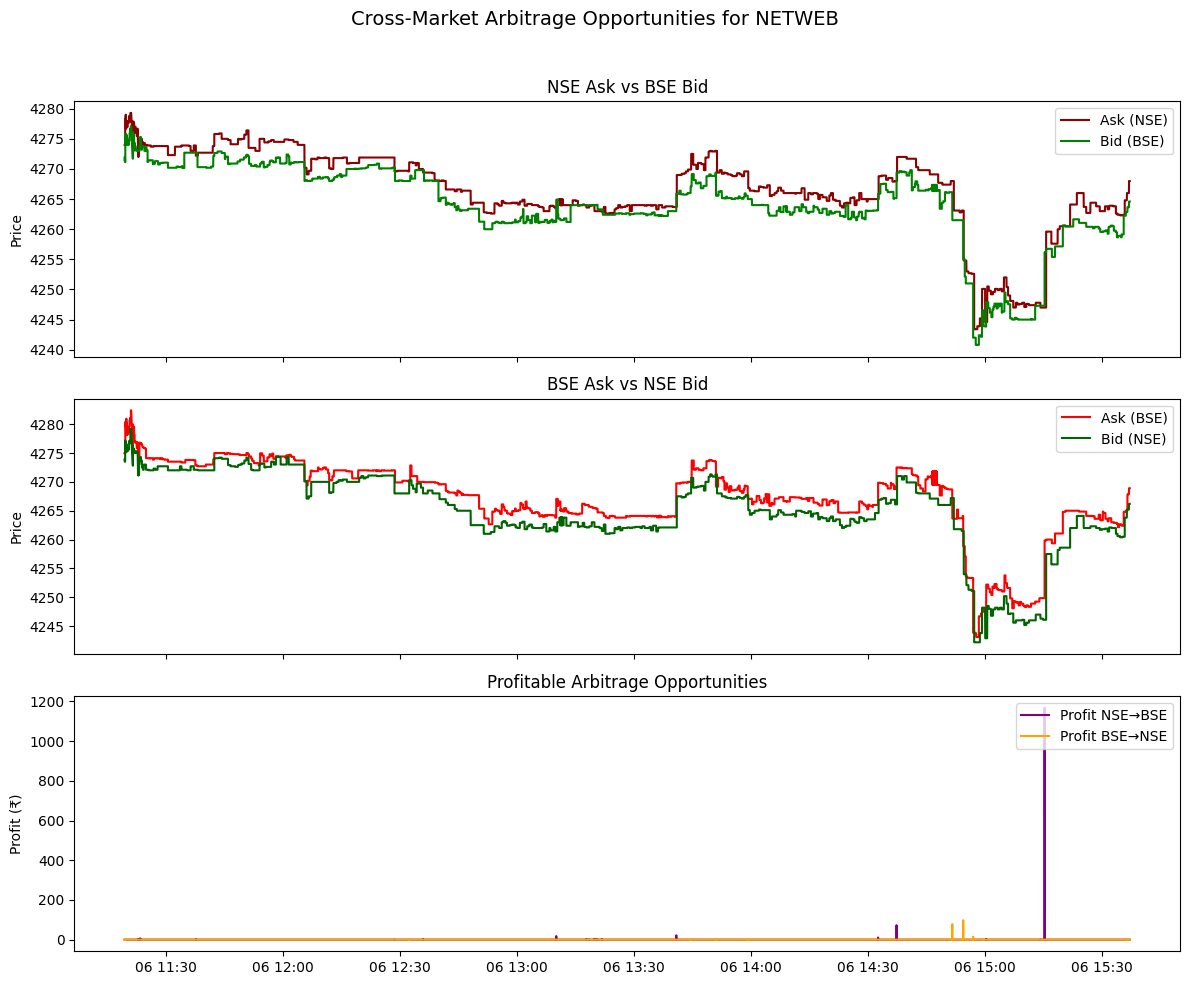

In [4]:

# ================================================ 
# Data extraction and processing for each stock 
# ================================================ 
db_path = "QI-03-OCT-25.db"

# ================================================ 
# Empty dataframe for profits to be charted later
# ================================================ 
all_profits = pd.DataFrame(columns=['datestamp', 'profit'])

for stock in tickers:
    nse_col = f"{stock}_NSE"
    bse_col = f"{stock}_BSE"

    try:
        # Load data
        conn = sqlite3.connect(db_path)
        query = f"SELECT datestamp, `{nse_col}`, `{bse_col}` FROM testTable ORDER BY datestamp ASC"
        df = pd.read_sql_query(query, conn)
        conn.close()

        df = df.fillna(method='ffill').fillna(method='bfill')

        # Extract bid/ask (replace extract_fields with your function)
        df[['BP_NSE','BQ_NSE','AP_NSE','AQ_NSE']] = df[nse_col].apply(extract_fields)
        df[['BP_BSE','BQ_BSE','AP_BSE','AQ_BSE']] = df[bse_col].apply(extract_fields)

        df['datestamp'] = pd.to_datetime(df['datestamp'])
        df = df.set_index('datestamp')

        # Arbitrage logic
        df['Spread_NSE_BSE'] = df['AP_NSE'] - df['BP_BSE']
        df['Qty_NSE_BSE'] = df[['AQ_NSE','BQ_BSE']].min(axis=1)
        df['PnL_NSE_BSE'] = (df['BP_BSE'] - df['AP_NSE']) * df['Qty_NSE_BSE']
        df['PnL_NSE_BSE'] = df['PnL_NSE_BSE'].mask(df['PnL_NSE_BSE'].eq(df['PnL_NSE_BSE'].shift()), 0)
        
        df['Spread_BSE_NSE'] = df['AP_BSE'] - df['BP_NSE']
        df['Qty_BSE_NSE'] = df[['AQ_BSE','BQ_NSE']].min(axis=1)
        df['PnL_BSE_NSE'] = (df['BP_NSE'] - df['AP_BSE']) * df['Qty_BSE_NSE']
        df['PnL_BSE_NSE'] = df['PnL_BSE_NSE'].mask(df['PnL_BSE_NSE'].eq(df['PnL_BSE_NSE'].shift()), 0)

        df['PnL_NSE_BSE'] = df['PnL_NSE_BSE'].clip(lower=0)
        df['PnL_BSE_NSE'] = df['PnL_BSE_NSE'].clip(lower=0)

        # =============================================================
        # Plotting only if the stock is NETWEB
        # =============================================================
        if stock == 'NETWEB':
            fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

            # Row 1: NSE Ask vs BSE Bid
            axes[0].plot(df.index, df['AP_NSE'], color='darkred', label='Ask (NSE)')
            axes[0].plot(df.index, df['BP_BSE'], color='green', label='Bid (BSE)')
            axes[0].set_ylabel("Price")
            axes[0].set_title("NSE Ask vs BSE Bid")
            axes[0].legend(loc="upper right")

            # Row 2: BSE Ask vs NSE Bid
            axes[1].plot(df.index, df['AP_BSE'], color='red', label='Ask (BSE)')
            axes[1].plot(df.index, df['BP_NSE'], color='darkgreen', label='Bid (NSE)')
            axes[1].set_ylabel("Price")
            axes[1].set_title("BSE Ask vs NSE Bid")
            axes[1].legend(loc="upper right")

            axes[2].plot(df.index, df['PnL_NSE_BSE'], color='purple', label='Profit NSE→BSE')
            axes[2].plot(df.index, df['PnL_BSE_NSE'], color='orange', label='Profit BSE→NSE')
            axes[2].set_ylabel("Profit (₹)")
            axes[2].set_title("Profitable Arbitrage Opportunities")
            axes[2].legend(loc="upper right")

            fig.suptitle(f"Cross-Market Arbitrage Opportunities for {stock}", fontsize=14)
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.savefig("plot.png", dpi=300)
            plt.show()

        # Row 3: Profitable Arbitrage Opportunities (>40)
        profitable_nse_bse = df[df['PnL_NSE_BSE'] > 40]['PnL_NSE_BSE'] - 40
        profitable_bse_nse = df[df['PnL_BSE_NSE'] > 40]['PnL_BSE_NSE'] - 40

        # Concatenate all profitable trades into a single DataFrame
        temp_df = pd.concat([
            pd.DataFrame({'datestamp': profitable_nse_bse.index, 'profit': profitable_nse_bse.values}),
            pd.DataFrame({'datestamp': profitable_bse_nse.index, 'profit': profitable_bse_nse.values})
        ])

        all_profits = pd.concat([all_profits, temp_df])

    except Exception as e:
        print(f"Skipping {stock} due to error: {e}")


**Explanation of the Arbitrage Logic**

As seen in the above graph, whenever the **ask price and ask quantity of one market** goes below the **bid price and bid quantity of another market**,  
a trade is triggered:

- The stock is **bought at the lower ask price** in one market.  
- The stock is **simultaneously sold at the higher bid price** in the other market.  
- The **quantity traded** is the minimum available across both sides, since this is the maximum that can be executed consistently:

            Q{trade} = min(AQ, BQ)


- The **profit from the trade** is the difference between the bid and ask prices multiplied by the traded quantity:

            PnL = (Ask - Bid) * Q{trade}


This ensures trades are only executed when there is a clear arbitrage opportunity across the two markets, with the profit constrained by the available order book depth.


# Final PnL Calculation

The cumulative PnL is computed and plotted to show the **total profit over the day** for all selected trades across all stocks


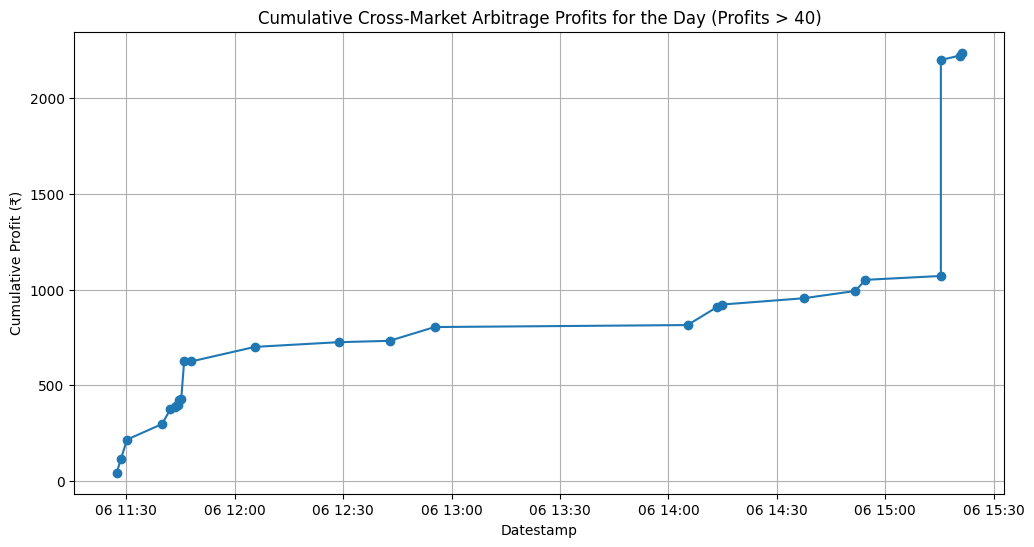

             datestamp   profit
0  2025-10-06 11:27:19    43.26
1  2025-10-06 11:28:32    74.28
2  2025-10-06 11:30:10    98.52
3  2025-10-06 11:39:54    81.80
4  2025-10-06 11:42:12    78.16
5  2025-10-06 11:43:33    12.50
6  2025-10-06 11:43:49     3.95
7  2025-10-06 11:44:21     3.40
8  2025-10-06 11:44:38    29.60
9  2025-10-06 11:45:10     0.60
10 2025-10-06 11:45:59   198.42
11 2025-10-06 11:48:00     0.50
12 2025-10-06 12:05:36    75.73
13 2025-10-06 12:28:42    24.48
14 2025-10-06 12:42:49     7.12
15 2025-10-06 12:55:17    72.00
16 2025-10-06 14:05:16    10.40
17 2025-10-06 14:13:32    95.20
18 2025-10-06 14:14:52    12.00
19 2025-10-06 14:37:23    32.80
20 2025-10-06 14:51:41    38.10
21 2025-10-06 14:54:29    58.05
22 2025-10-06 15:15:22    20.30
23 2025-10-06 15:15:22  1128.40
24 2025-10-06 15:20:35    23.00
25 2025-10-06 15:21:15    14.90


In [5]:
# ================================================================
# Plot cumulative profit charts if all trades are taken
# ================================================================
all_profits['datestamp'] = pd.to_datetime(all_profits['datestamp'])
all_profits = all_profits.sort_values('datestamp').reset_index(drop=True)

ProfitPrint = all_profits.copy()

# Compute cumulative sum
all_profits['cumsum_profit'] = all_profits['profit'].cumsum()

# Plot final cumulative profits
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(all_profits['datestamp'], all_profits['cumsum_profit'], marker='o')
plt.xlabel('Datestamp')
plt.ylabel('Cumulative Profit (₹)')
plt.title('Cumulative Cross-Market Arbitrage Profits for the Day (Profits > 40)')
plt.grid(True)
plt.show()

print(ProfitPrint)

## Execution Considerations and Latency Challenges

While this analysis identifies **profitable cross-market arbitrage opportunities**, it is important to note the practical challenges in real-world execution:

1. **High-Speed Execution Required**  
   - Arbitrage opportunities exist for **milliseconds to a few seconds** before prices converge.  
   - Institutional traders use **co-located servers, low-latency networks, and algorithmic trading systems** to capture these fleeting opportunities.

2. **Latency Limitations for Retail Traders**  
   - Retail traders experience **higher network latency and order processing delays**.  
   - By the time an order reaches the exchange, the arbitrage window may already be gone, making profits difficult or impossible to realize.

3. **Broker and Market Limitations**  
   - Even with fast brokers like Zerodha, **order placement and matching times** are slower than institutional setups.  
   - Slippage and partial fills further reduce potential profits.

